# Вариационный Автокодировщик (VAE)

### Шаг 1 - Импорт необходимых библиотек

In [1]:
# Tensorflow / Keras
from tensorflow import keras # для построения нейронной сети
print('Tensorflow/Keras: %s' % keras.__version__) # посмотреть версию
from keras.models import Model # для создания сборки модели нейронной сети
from keras import Input # для создания тензора и указания входящих размерностей
from keras.layers import Dense, Lambda # требуемые слои модели нейронной сети
from tensorflow.keras.utils import plot_model # для визуализации схемы модели
from keras import backend as K # для репараметризации и создания пользовательской функции потерь

import numpy as np # для векторизованных вычислений
print('numpy: %s' % np.__version__) # посмотреть версию

# Визуализация процесса обучения
import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: %s' % matplotlib.__version__) # посмотреть версию
# import graphviz # визуализация схемы модели
# print('graphviz: %s' % graphviz.__version__) # print version
# import plotly
from plotly.express import scatter # для визуализации данных
# print('plotly: %s' % plotly.__version__) # посмотреть версию

# Другие утилиты
import sys
import os

# Назначить переменную основного каталога
main_dir=os.path.dirname(sys.path[0])
#print(main_dir)

Tensorflow/Keras: 2.8.0
numpy: 1.21.6
matplotlib: 3.2.2


### Шаг 2 - Загрузка MNIST

Shape of X_train:  (60000, 28, 28)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


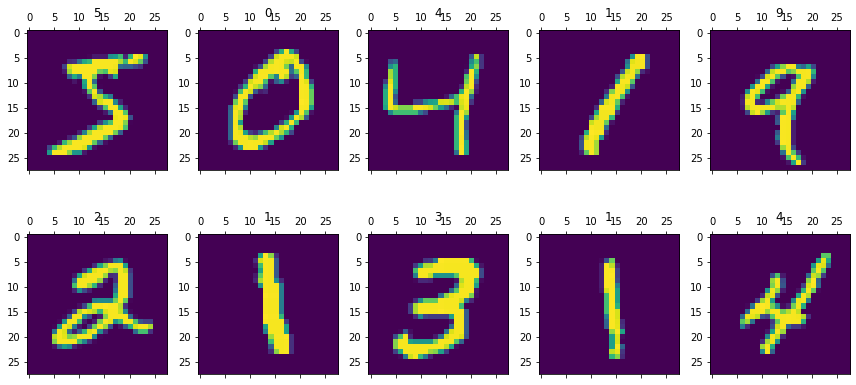

In [8]:

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# вывести размерности данных
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

# Нормализация данных 
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# изображения первых 10 цифр обучающего набора и их метки.
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_train[n])
        axs[i,j].set(title=y_train[n])
        n=n+1
plt.show() 

##### переформатировать входные картинки в одноразмерные векторы (flatten images)

In [15]:
X_train.reshape((len(X_train),-1)).shape

(60000, 784)

In [16]:
X_train = X_train.reshape((len(X_train),-1))
X_test = X_test.reshape((len(X_test),-1))

# Вывести новые размерности
print("New shape of X_train: ", X_train.shape)
print("New shape of X_test: ", X_test.shape)

New shape of X_train:  (60000, 784)
New shape of X_test:  (10000, 784)


### Шаг 3. Создание модели вариационного автоэнкодера.

##### Функция, которая будет использоваться для Z-выборки

Мы используем прием репараметризации, который позволяет обратное распространение потерь через узлы среднего значения и дисперсии, поскольку они детерминированы при разделении узла выборки путем добавления недетерминированного параметра эпсилон. Это делает z детерминированным, а обратное распространение прекрасно работает. Эпсилон можно рассматривать как случайный шум, используемый для поддержания требуемой стохастичности z. Здесь эпсилон выбирается из стандартного нормального распределения (среднее=0., дисперсия=1.).

In [17]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

##### Модель кодировщика

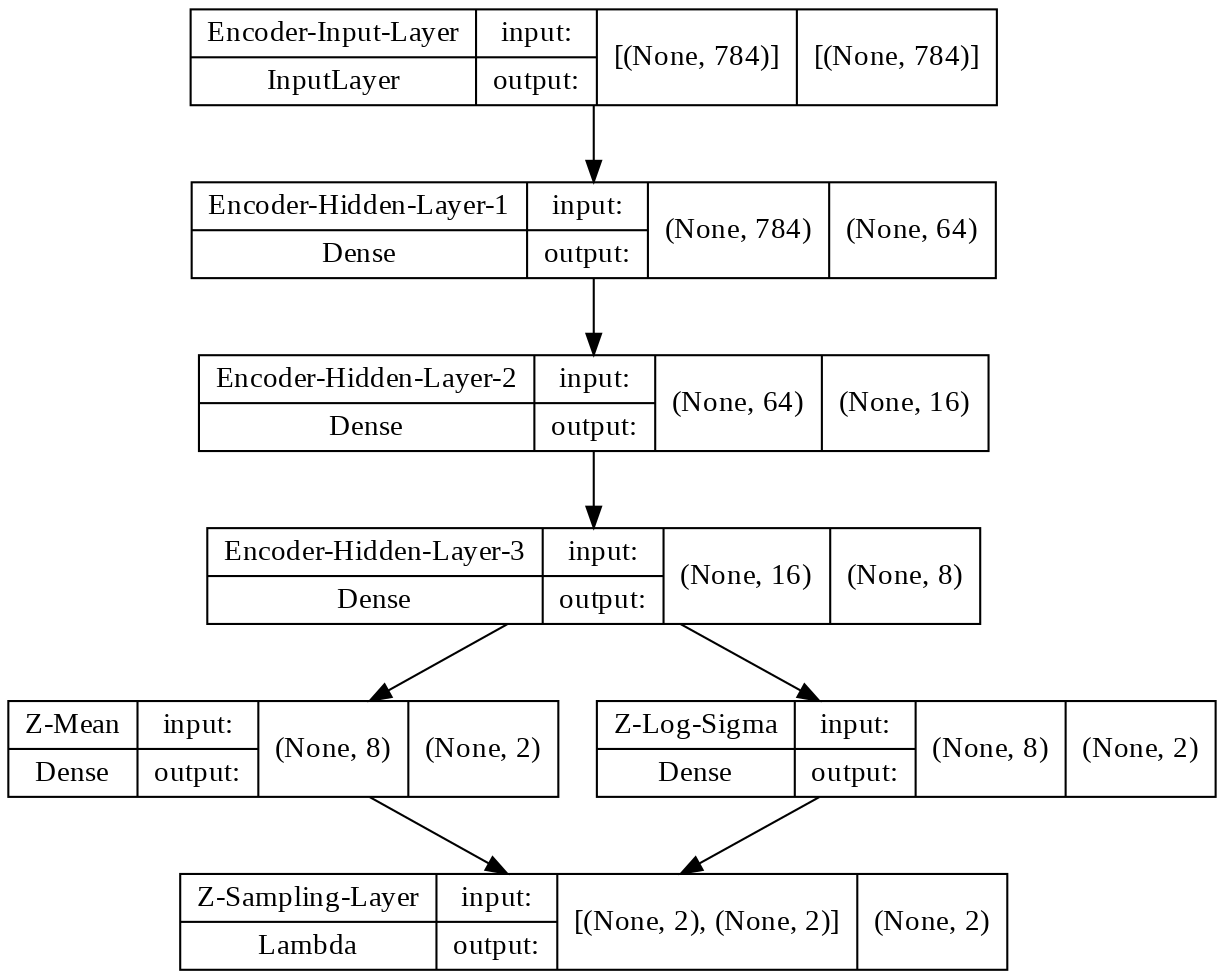

In [20]:
# размерности для входных/выходных слоев и слоев латентного пространства.
original_dim = 784 # Количество нейронов входящего слоя (28 * 28 = 784)
latent_dim = 2 # Размерность скрытого слоя

#--- Входящий слой
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

#--- Скрытый слой
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

#--- Пользовательский слой латентного пространства
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Компонент "среднее нормального распределения"
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Компонент "дисперсия нормального распределения"
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Слой выборки Z

#--- Модель кодировщика
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# Визуализация схемы модели кодировщика
plot_model(encoder, show_shapes=True, dpi=150)
#plot_model(encoder, to_file=main_dir+'/pics/Encoder.png', show_shapes=True, dpi=300)

##### Модель декодера

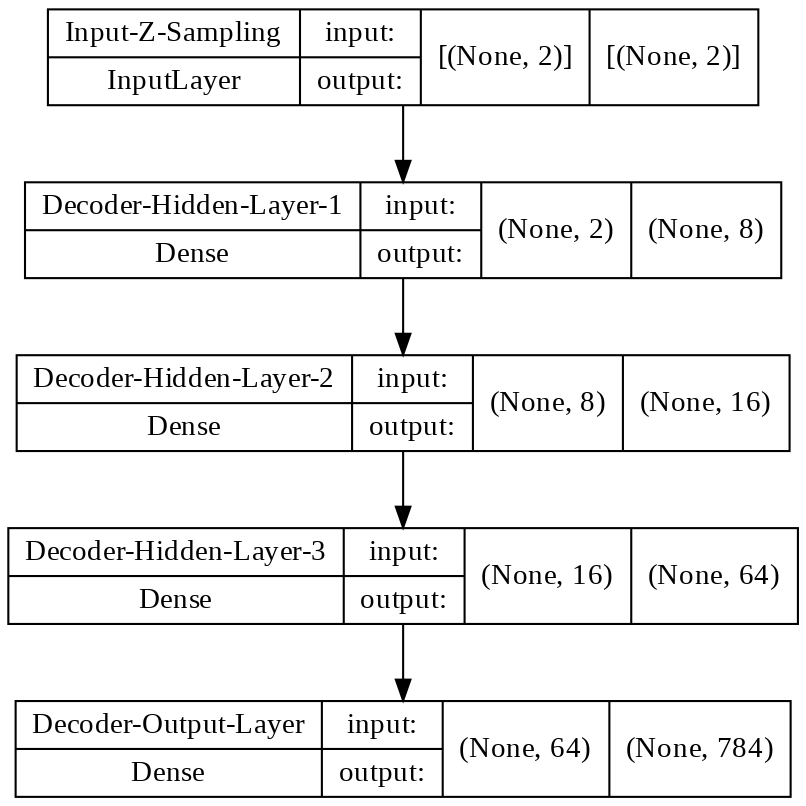

In [19]:
#--- Входящий слой (из латентного пространства)
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Скрытый слой
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

#--- Выходящий слой
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

#--- создается модель декодера
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

# Визуализация схемы модели декодера
plot_model(decoder, show_shapes=True, dpi=150)
#plot_model(decoder, to_file=main_dir+'/pics/Decoder.png', show_shapes=True, dpi=300)

In [21]:
# Определение выхода модели VAE, последовательным выполнением кодировщика и декодера
outpt = decoder(encoder(visible)[2]) # Обратите внимание, выходы, доступные из кодировщика - это z_mean, z_log_sigma и z. Мы забираем z, указывая индекс [2]
# собираем модель вариационного автокодировщика
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

##### Наша собственная функция потерь

Чем дальше выход кодировщика Z от стандартного нормального распределения, тем сильнее функция потерь "Расхождение Кульбака-Лейблера" (KL-дивергенция) будет его штрафовать. 

KL-дивергенция действует как регуляризатор, сохраняющий Z достаточно разнообразными. Если бы мы не использовали регуляризатор, кодировщик мог бы научиться обманывать и давать каждой точке данных кодировку в другой области евклидова пространства. Другими словами, KL-дивергенция двигает параметры нормального распределения вероятностей $\mu$ и $\sigma$, в сторону параметров **стандартного нормального распределения**: (0, 1).

In [22]:
# Потери при реконструкции изображения сравнивают входы и выходы и пытаются минимизировать разницу.
r_loss = original_dim * keras.losses.mse(visible, outpt)  # используется функция MSE

# функция потерь KL-дивергенция сравнивает кодированное латентное распределение Z со стандартным нормальным распределением и штрафует, если они слишком отличаются
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# Потери VAE - это комбинация потерь на реконструкции и KL-дивергенции
vae_loss = K.mean(r_loss + kl_loss)

# Добавим функцию потерь в модель и скомпилируем ее.
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

##### Тренировка модели VAE

In [23]:
history = vae.fit(X_train, X_train, epochs=25, batch_size=32, validation_data=(X_test, X_test))

Epoch 1/25
1875/1875 [==============================] - 13s 5ms/step - loss: 52.2229 - val_loss: 46.7076
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 44.5022 - val_loss: 42.0358
Epoch 3/25
1875/1875 [==============================] - 10s 5ms/step - loss: 41.0000 - val_loss: 40.1822
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 39.3813 - val_loss: 38.7491
Epoch 5/25
1875/1875 [==============================] - 10s 5ms/step - loss: 38.2123 - val_loss: 37.6301
Epoch 6/25
1875/1875 [==============================] - 10s 5ms/step - loss: 37.4513 - val_loss: 37.0723
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 36.8264 - val_loss: 36.5670
Epoch 8/25
1875/1875 [==============================] - 10s 5ms/step - loss: 36.3909 - val_loss: 36.2228
Epoch 9/25
1875/1875 [==============================] - 10s 5ms/step - loss: 36.0085 - val_loss: 36.0692
Epoch 10/25
1875/1875 [==============================] - 1

##### Выведем графики процесса обучения

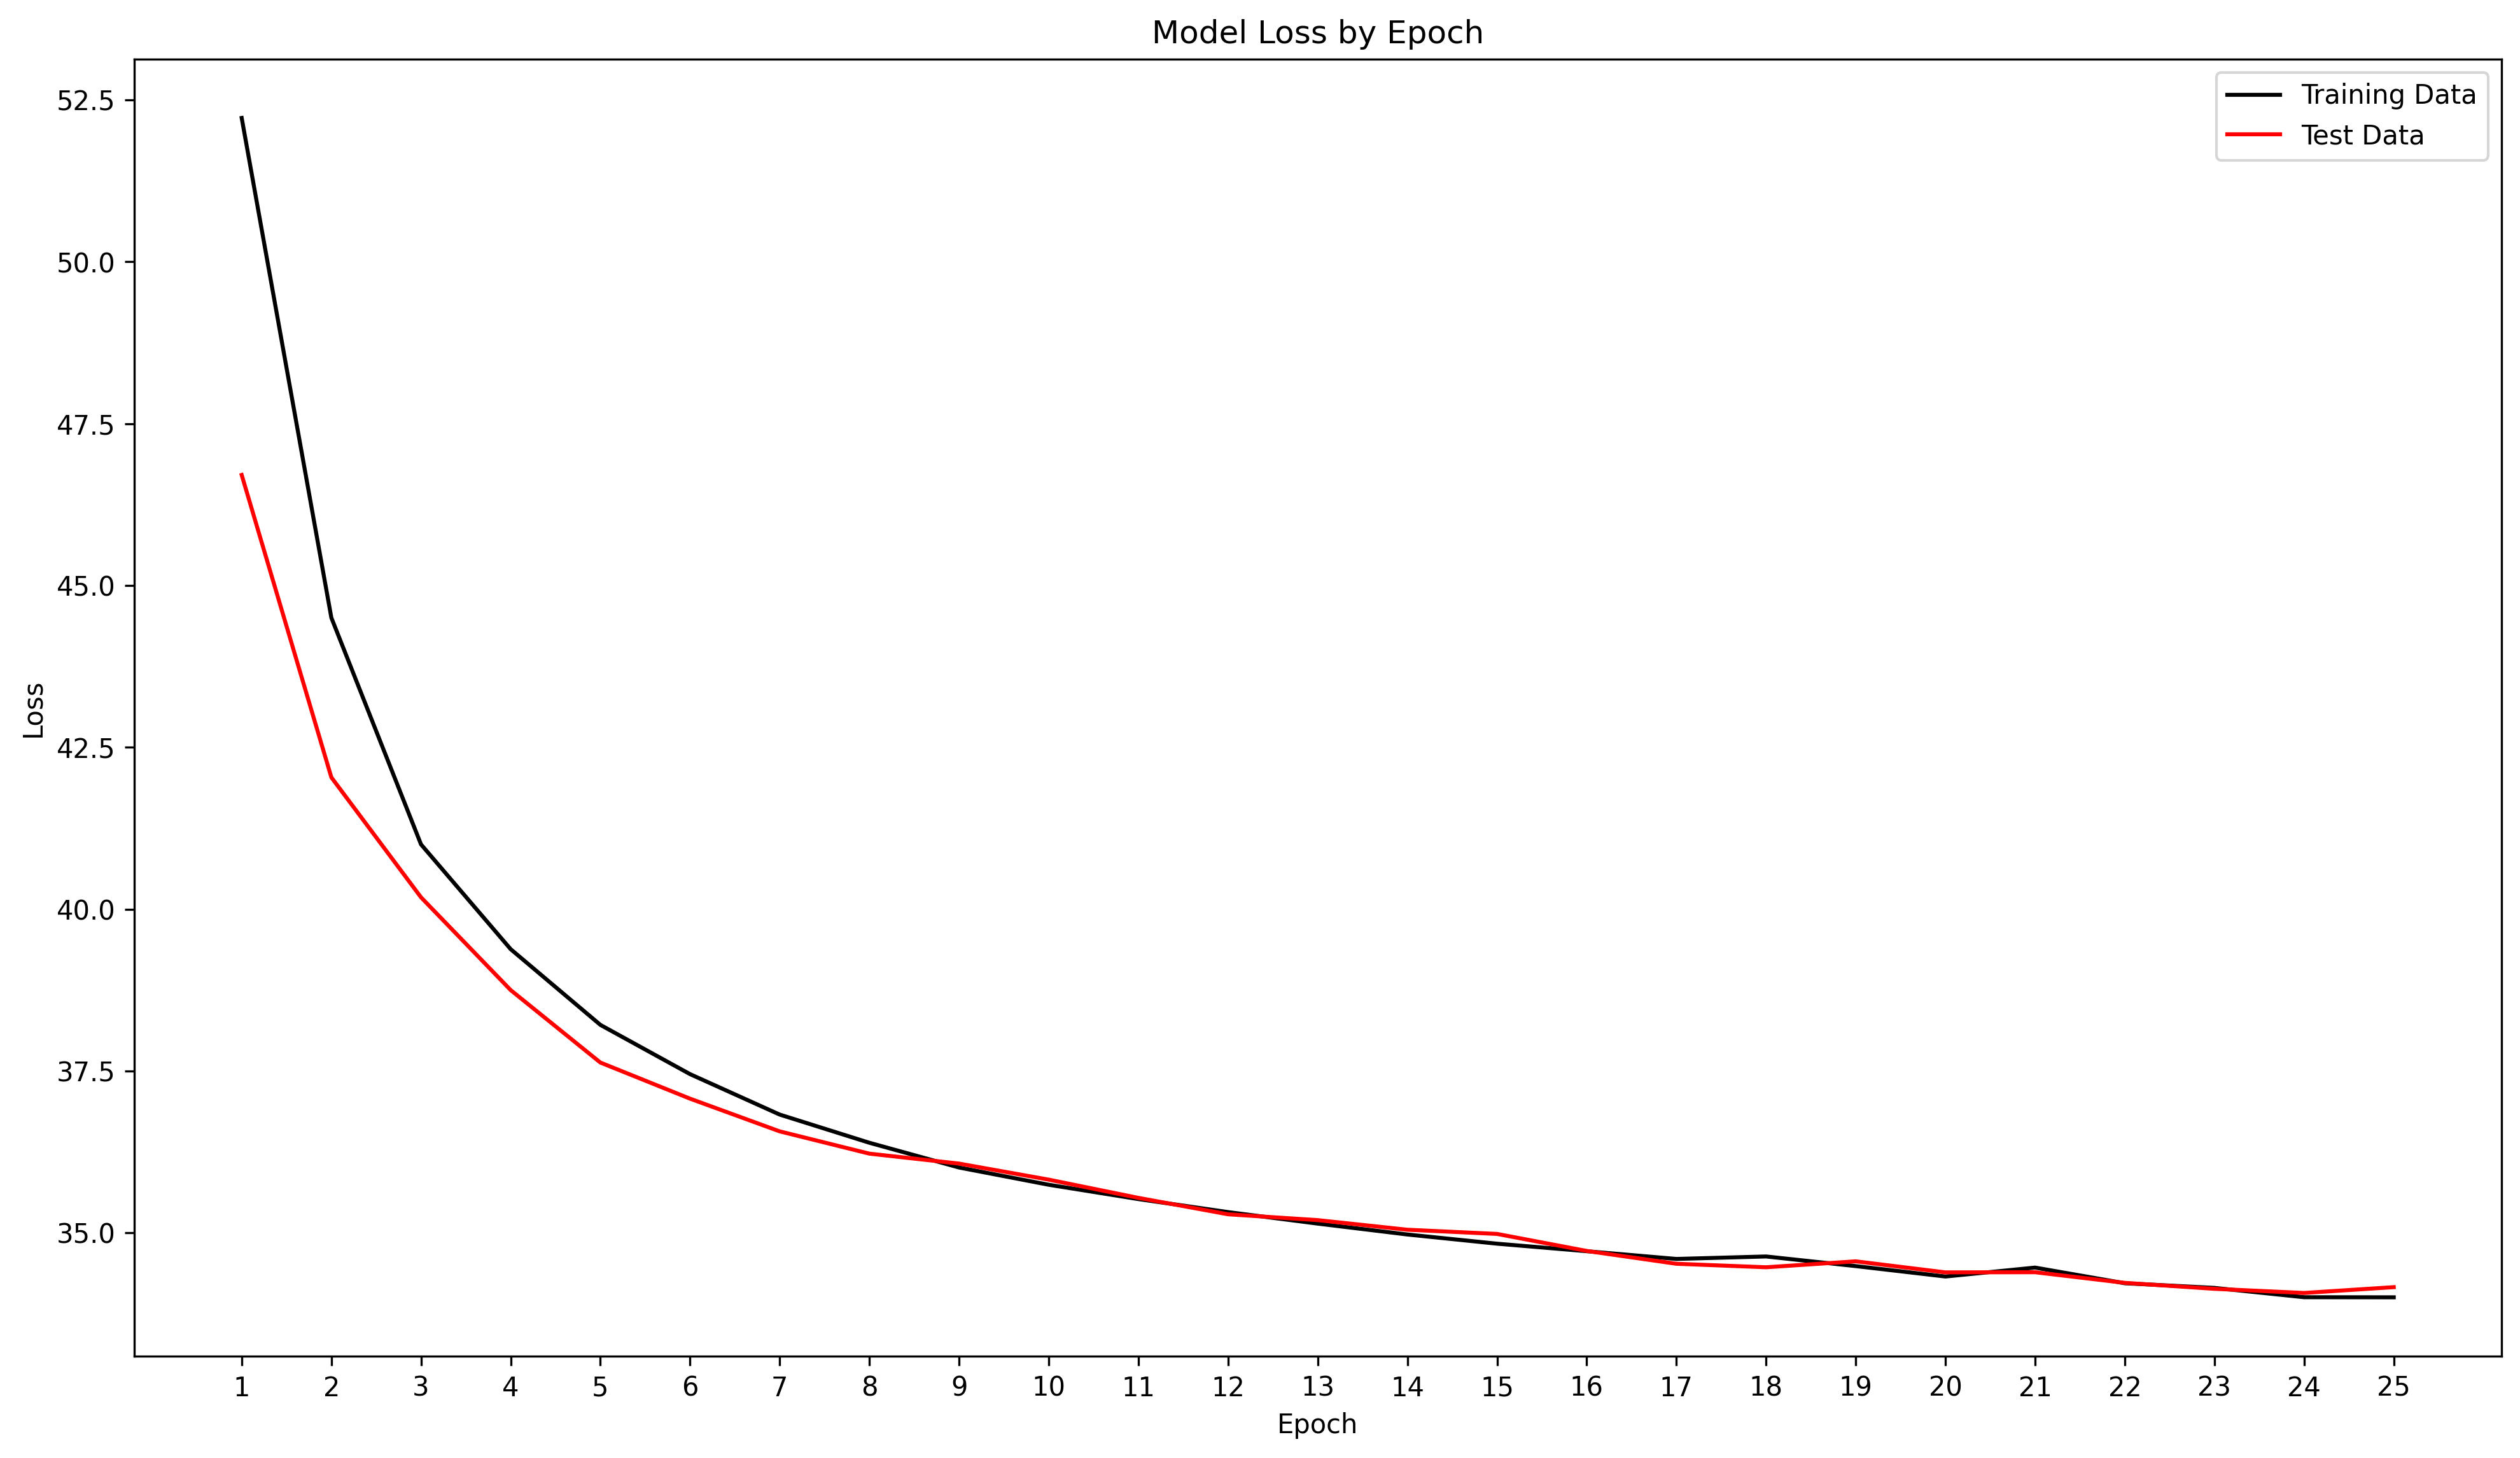

In [24]:
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()

plt.show()

##### Визуализация латентного пространства

Поскольку наше латентное пространство двумерно, мы можем визуализировать окрестности разных цифр на двумерной плоскости:

In [25]:
# Используем модель кодировщика для кодирования входных изображений в латентное пространство
X_test_encoded = encoder.predict(X_test)

# Напомним, что наш кодировщик возвращает 3 массива: z-mean, z-log-sigma и z. Мы выбираем значения z
# Создадим точечную диаграмму
# точки будут различаться десятью цветами, номера цветов в палитре выбираются по метке y
fig = scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1], 
                 opacity=1, color=y_test.astype(str))

# Изменение цвета фона
fig.update_layout(dict(plot_bgcolor = 'white'), margin=dict(l=0, r=0, t=40, b=0))

# задание осей координат
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

# Заголовок диаграммы
fig.update_layout(title_text="представление цифр MNIST в 2D латентном пространстве")

# Размеры маркеров
fig.update_traces(marker=dict(size=2))

fig.show()

Each of these colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).
Каждый цвет кластера сооветствует типу цифры. Близкие кластеры — это графически похожие цифры (т. е. цифры, которые имеют общую информацию в латентном пространстве).

Поскольку VAE — это генеративная модель, мы также можем использовать ее для генерации новых цифр! Здесь мы будем сканировать латентную плоскость, выбирая точки через равные промежутки и генерируя соответствующую цифру для каждой из этих точек. Это даст нам визуализацию латентного многообразия, которое «генерирует» цифры MNIST.

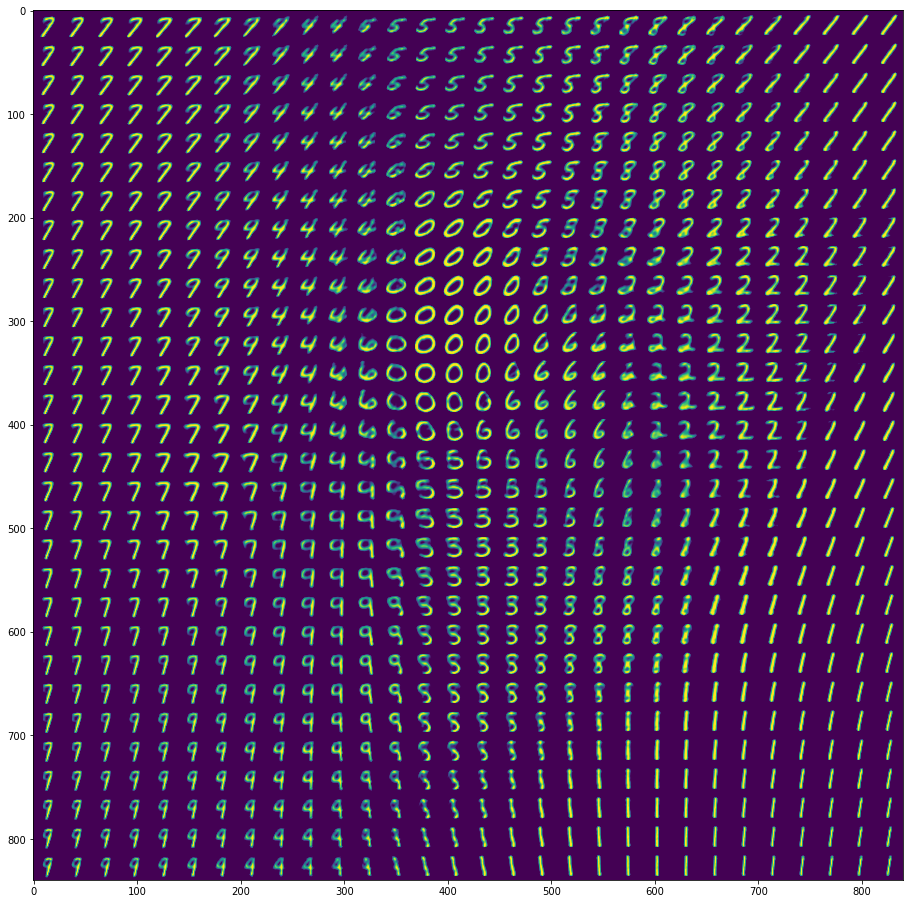

In [26]:
# 2D-Отображение многообразия цифр
n = 30  # Раскладка из 30x30 из цифр
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Мы выберем  n точек с дисперсией [-1.5, 1.5]
grid_x = np.linspace(1.5, -1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Генерация изображения с использованием обученного декодера
        x_decoded = decoder.predict(z_sample)
        x_decoded = np.clip(x_decoded, 0.25, 0.75) # мы используем функцию clip, чтобы сделать края цифр толще
        # Преформируем вектор из одноразмерного с размерностью 784 к изначальному размеру цифр (28x28)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()

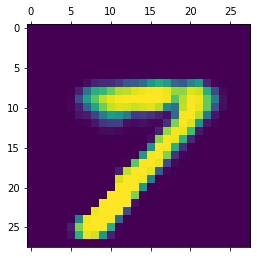

In [ ]:
# Введем координаты латентного пространства
z_sample_digit=[[0,2.5]]

# Декодируем координаты латентного пространства (т. е. генерируем новые выходные данные)
digit_decoded = decoder.predict(z_sample_digit)

# Изменить форму к 28х28 и отобразить изображение
plt.matshow(digit_decoded.reshape(28,28))
plt.show()

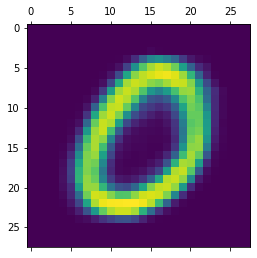

In [27]:
# # Введем координаты латентного пространства
z_sample_digit=[[0,0.4]]

# Декодируем координаты латентного пространства (т. е. генерируем новые выходные данные)
digit_decoded = decoder.predict(z_sample_digit)

# Изменить форму к 28х28 и отобразить изображение
plt.matshow(digit_decoded.reshape(28,28))
plt.show()

Еще один вариант вариационного автокодировщика, использующий свертки и немного измененную функию потерь:

[Сверточный вариационный автоэнкодер](https://www.tensorflow.org/tutorials/generative/cvae)